In [1]:
import torch.nn as nn
import torch.nn.functional as F
import gym
from torch.optim import Adam
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(MLP, self).__init__()
        # define 4 linear layers
        # 1 for the input
        # 1 hiddem
        # 1 for the policy output
        # 1 for the state value ouput
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.pol_layer = nn.Linear(hidden_dim, output_dim)
        self.val_layer = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # create the forward computation of the network
        # this function should return both the policy and the state value
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        policy = F.softmax(self.pol_layer(h), dim=-1)
        value = self.val_layer(h)
        return policy, value
        

In [6]:
def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)
        

In [7]:
# do not change the seeds or the parameters
# the code is fragile due to lack of many methods
# experience replay, n-step returns, batch computations
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)
num_actions = 2
num_obs = 4
hiddem_dim = 64
network = MLP(num_obs, num_actions, hiddem_dim)
target_network = MLP(num_obs, num_actions, hiddem_dim)
hard_update(target_network, network)
optimizer = Adam(network.parameters(), lr=0.0005)

In [8]:
env = gym.make('CartPole-v1')
env.seed(seed)
act_num = 2

In [9]:
t = 0
rewards = []
average_rewards = []
for ep_i in range(351):
    done = False
    obs = env.reset()
    # transform the numpy array to torch tensor
    obs = torch.Tensor(obs)

    total_reward = 0
    while not done:
        # compute the policy for the current observation
        policy, _ = network(obs)
        
        # sample from the categorical distribution that was created
        a = np.random.choice([0,1], p=policy.detach().numpy())
        
        # for rendering remove the code below
        # env.render()
        
        # make a step forward in the environemnt
        next_obs, reward, done, _ = env.step(a)
    
        # transform the numpy array to torch tensor
        next_obs = torch.Tensor(next_obs)
        total_reward += reward
            
        t += 1
        ########################################
        #        BEGINNING OF TRAINING         #
        ########################################
        # initialized the optimzer
        optimizer.zero_grad()
        
        # compute the target value r + \gamma * V(s')
        if not done:
            target_value = torch.Tensor([reward]) + 0.99 * target_network(next_obs)[1]
        else:
            target_value = torch.Tensor([reward])
        
        # compute the value of this observation
        value = network(obs)[1]
        
        # compute the advantage for the policy gradient
        advantage = target_value - value
        
        # compute the td error
        td_loss = 0.5 * (value - target_value.detach())**2
        
        # compute the policy gradient error L = - advantage * log(policy)
        # make sure that you compute the policy gradient only for the action that was executed before
        pg_loss = -advantage.detach() * torch.log(policy[a])
        
        # compute the entory for the current policy
        # entropy = - sum(policy*log(policy))
        entropy = -torch.sum(policy * torch.log(policy))
        
        # add the two errors and substract the entropy
        loss = td_loss + pg_loss - 0.1 * entropy
        
        # compute the gradients using backprop
        loss.backward()
        
        # make an optimization step
        optimizer.step()
        ########################################
        #        END OF TRAINING               #
        ########################################
        
        #update the current observation from the next observation
        obs = next_obs
        
        # update the parameters of the target network using the 
        # function hard update
        if t % 1000 == 0:
            hard_update(target_network, network)
        
        if done:
            if ep_i % 50 ==0:
                print('Episode:', ep_i + 1, 'Reward:', total_reward)
            rewards.append(total_reward)
            if ep_i % 10 ==0:
                average_rewards.append(sum(rewards) / 10.0)
                rewards = []
            break
            
        

Episode: 1 Reward: 13.0
Episode: 51 Reward: 27.0
Episode: 101 Reward: 30.0
Episode: 151 Reward: 17.0
Episode: 201 Reward: 57.0
Episode: 251 Reward: 22.0
Episode: 301 Reward: 36.0
Episode: 351 Reward: 222.0


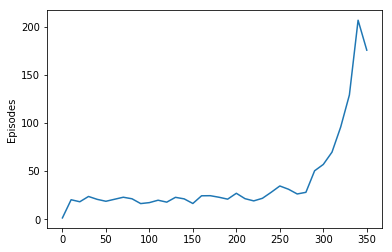

In [10]:
episodes = np.arange(36) * 10
plt.plot(episodes, average_rewards)
plt.ylabel('Average rewards per 10 episodes')
plt.ylabel('Episodes')
plt.show()